# Analysis of EOD simulations of BSE detection in HR and UHR-mode
---

#### Overview
Visualization of BSE detection as a function of landing energy (LE), stage bias (SB), imaging mode, and working distance. For simplicity, simulated BSE energy is equal to the LE being simulated. Kinetic energy of the BSE at time of collision is also recorded. All data was generated from EOD simulations.

In [1]:
from pathlib import Path
from textwrap import dedent
import subprocess
from itertools import product
from multiprocessing import Pool

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import altair as alt

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Visualizing BSE trajectories
---

### Input microscope working distance and BSE detector width

In [2]:
# Set working distance [3mm, 4mm, 5mm, or 6mm]
WD = 5  # mm

### Load trajectory data

In [3]:
# Working distances
WDs = [3, 4, 5, 6]
# Initialize DataFrame
df_trj = pd.DataFrame()

# Loop through trajectory data (stored in separate csvs)
for WD_ in WDs:
    fp = Path(f'../data/BSE_trajectories/BSE_trajectories_{WD_}mm-WD.csv')
    df = pd.read_csv(fp)
    df['WD'] = WD_
    df_trj = pd.concat([df_trj, df])

# Preview
df_trj.sample(10)

i          Z         R            K mode    E0    SB      theta  WD
190970  75 -59.514522  2.091852  3999.815871  UHR  1000  3000  30.199416   3
74413   30   2.217036  2.846045  3809.150175   HR  2000  3000  57.206566   5
20241   11   0.365699  6.481491  1063.470571   HR  1000   100  71.393079   3
292153  20   4.343308  1.335040  2999.999886  UHR  3000     0  63.973391   5
152238  67   1.373016  1.004830  1066.208852  UHR  1000   100  35.284644   3
240122   1  61.466501  7.923095  2000.000002  UHR  2000     0  88.187846   5
73090   92   3.041497  0.285085  3027.568999   HR  3000   100  16.602995   4
232335  15  10.088798  9.150590  2000.000137  UHR  2000     0  67.851831   6
255621  24   1.378321  2.428817  3509.417501  UHR  2000  2000  61.147644   4
84420   11   2.561858  5.473886  3499.048812   HR  3000  1000  71.393079   5

### Trajectory analysis

In [4]:
def plot_trajectories(WD, mode='HR'):
    """Plot BSE trajectories given a working distance (mm) and mode (HR vs UHR)"""
    # Set up FacetGrid
    # ----------------
    source = df_trj.loc[(df_trj['WD'] == WD) &\
                        (df_trj['mode'] == mode)]
    g = sns.FacetGrid(source, row='E0', col='SB', height=4, aspect=1.5)
    colors = sns.cm.icefire(np.linspace(0, 1, 10))
    cmap = sns.blend_palette(colors, as_cmap=True)

    # Plot BSE trajectories
    # ---------------------
    K_min = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).min()
    K_max = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).max()
    for j, ((E0, SB), grp) in enumerate(source.groupby(['E0', 'SB'])):
        # Choose axis
        ax = g.axes.flat[j]
        # Iterate through particles
        for i, particle in grp.groupby('i'):
            if not i % 5:  # only plot every nth BSE trajectory
                K_f = particle['K'].iloc[-1]  # Final KE of particle i
                K_rel = (K_f - K_min) / (K_max - K_min)  # Scale final KE
                ax.plot(particle['Z'], particle['R'], color=cmap(K_rel), alpha=0.7)
        # Aesthetics
        title = f'E0={E0}eV | SB={SB}V'
        ax.set_title(title)
        ax.set_xlim(-3, 7)
        ax.set_ylim(0, 5)
        ax.set_aspect('equal')
        ax.grid(ls=':')
    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=K_min, vmax=K_max))
    g.fig.colorbar(sm, ax=g.axes.ravel())

    # Add sample <--> detector geometry
    # ---------------------------------
    # EOD element outlines
    Z0 = 0.57  # mm (BSE detector width)
    elements = {
        'CBS_detector': [[0.00, 4.00],
                         [  Z0, 4.00],
                         [  Z0, 0.75],
                         [0.00, 0.75]],
        'polepiece': [[-5.00, 5.00],
                      [ 0.00, 2.00],
                      [ 0.00, 1.50],
                      [-5.00, 2.50]],
        'stage': [[   WD, 4.80],
                  [ WD+2, 4.80],
                  [ WD+2, 0.00],
                  [   WD, 0.00]]
    }
    # Plot geometry
    for ax in g.axes.flat:
        # Create patches
        patches = []
        for element, coords in elements.items():
            polygon = Polygon(coords)
            patches.append(polygon)
        # Make PatchCollection
        cmap = sns.diverging_palette(250, 15, s=75, l=40, center='dark', as_cmap=True)
        pc = PatchCollection(patches, cmap=cmap, alpha=0.6)
        colors = np.arange(len(patches))
        pc.set_array(colors)
        # Plot onto figure
        ax.add_collection(pc)

### Plot BSE trajectories | 4mm WD | HR-mode

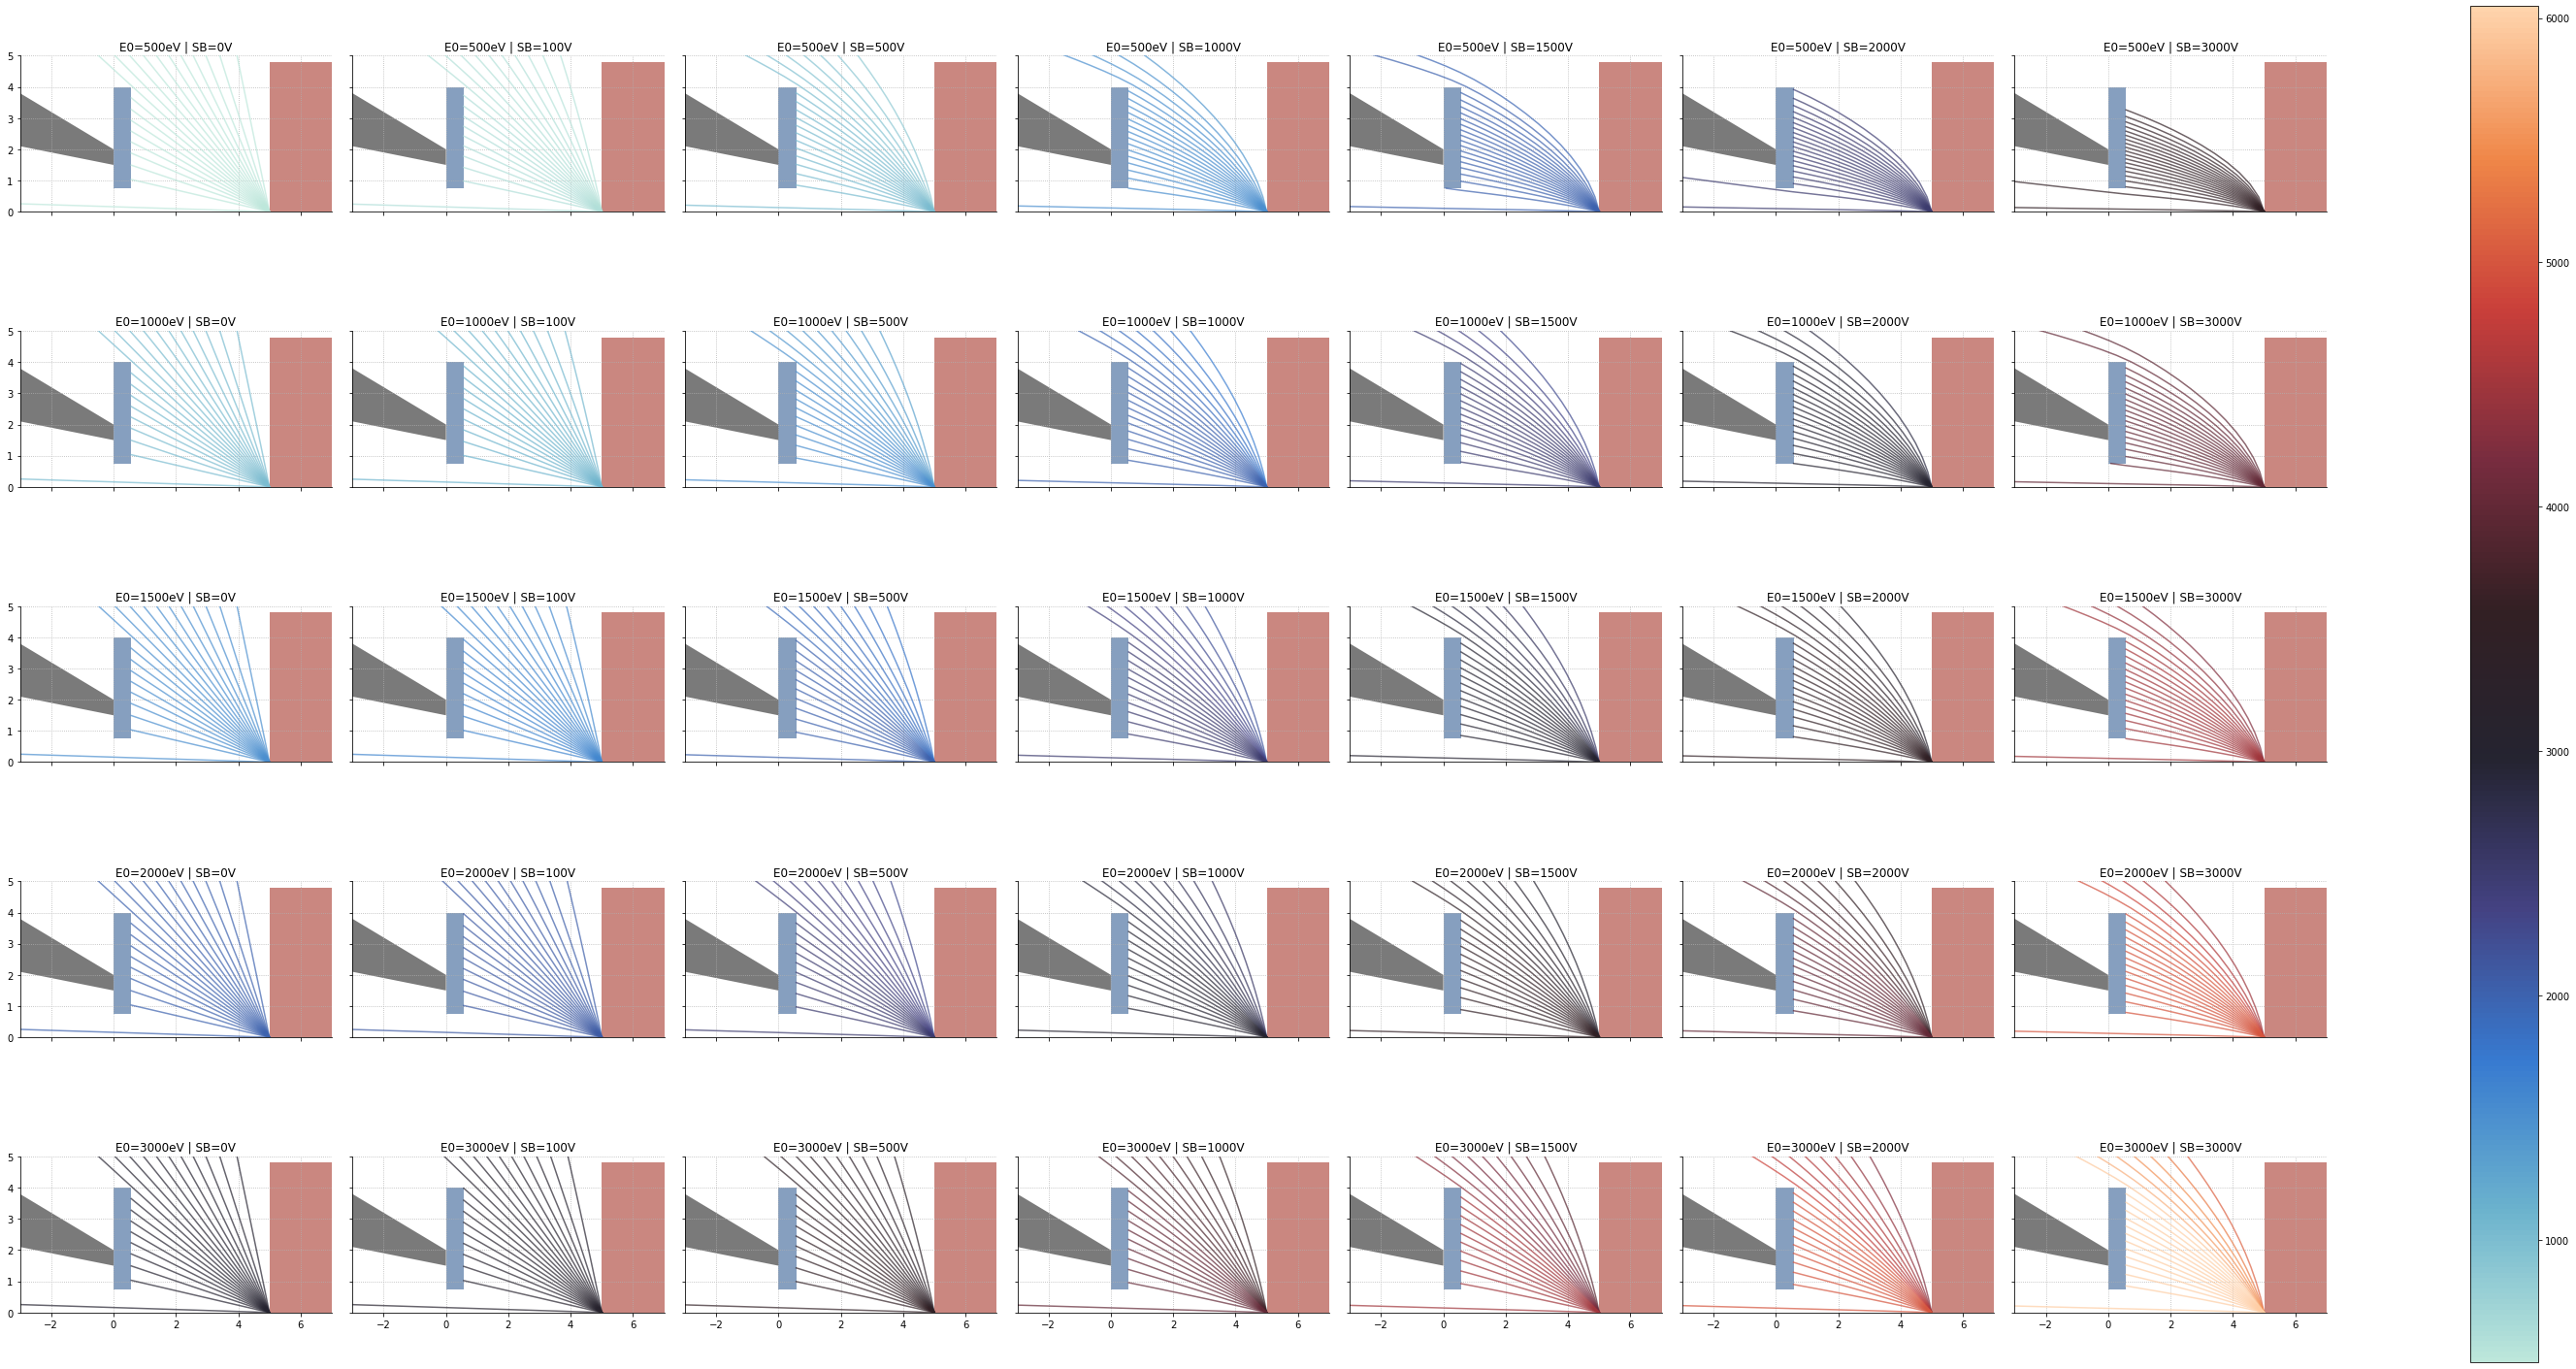

In [5]:
plot_trajectories(WD=WD, mode='HR')

### Plot BSE trajectories | 5mm WD | UHR-mode

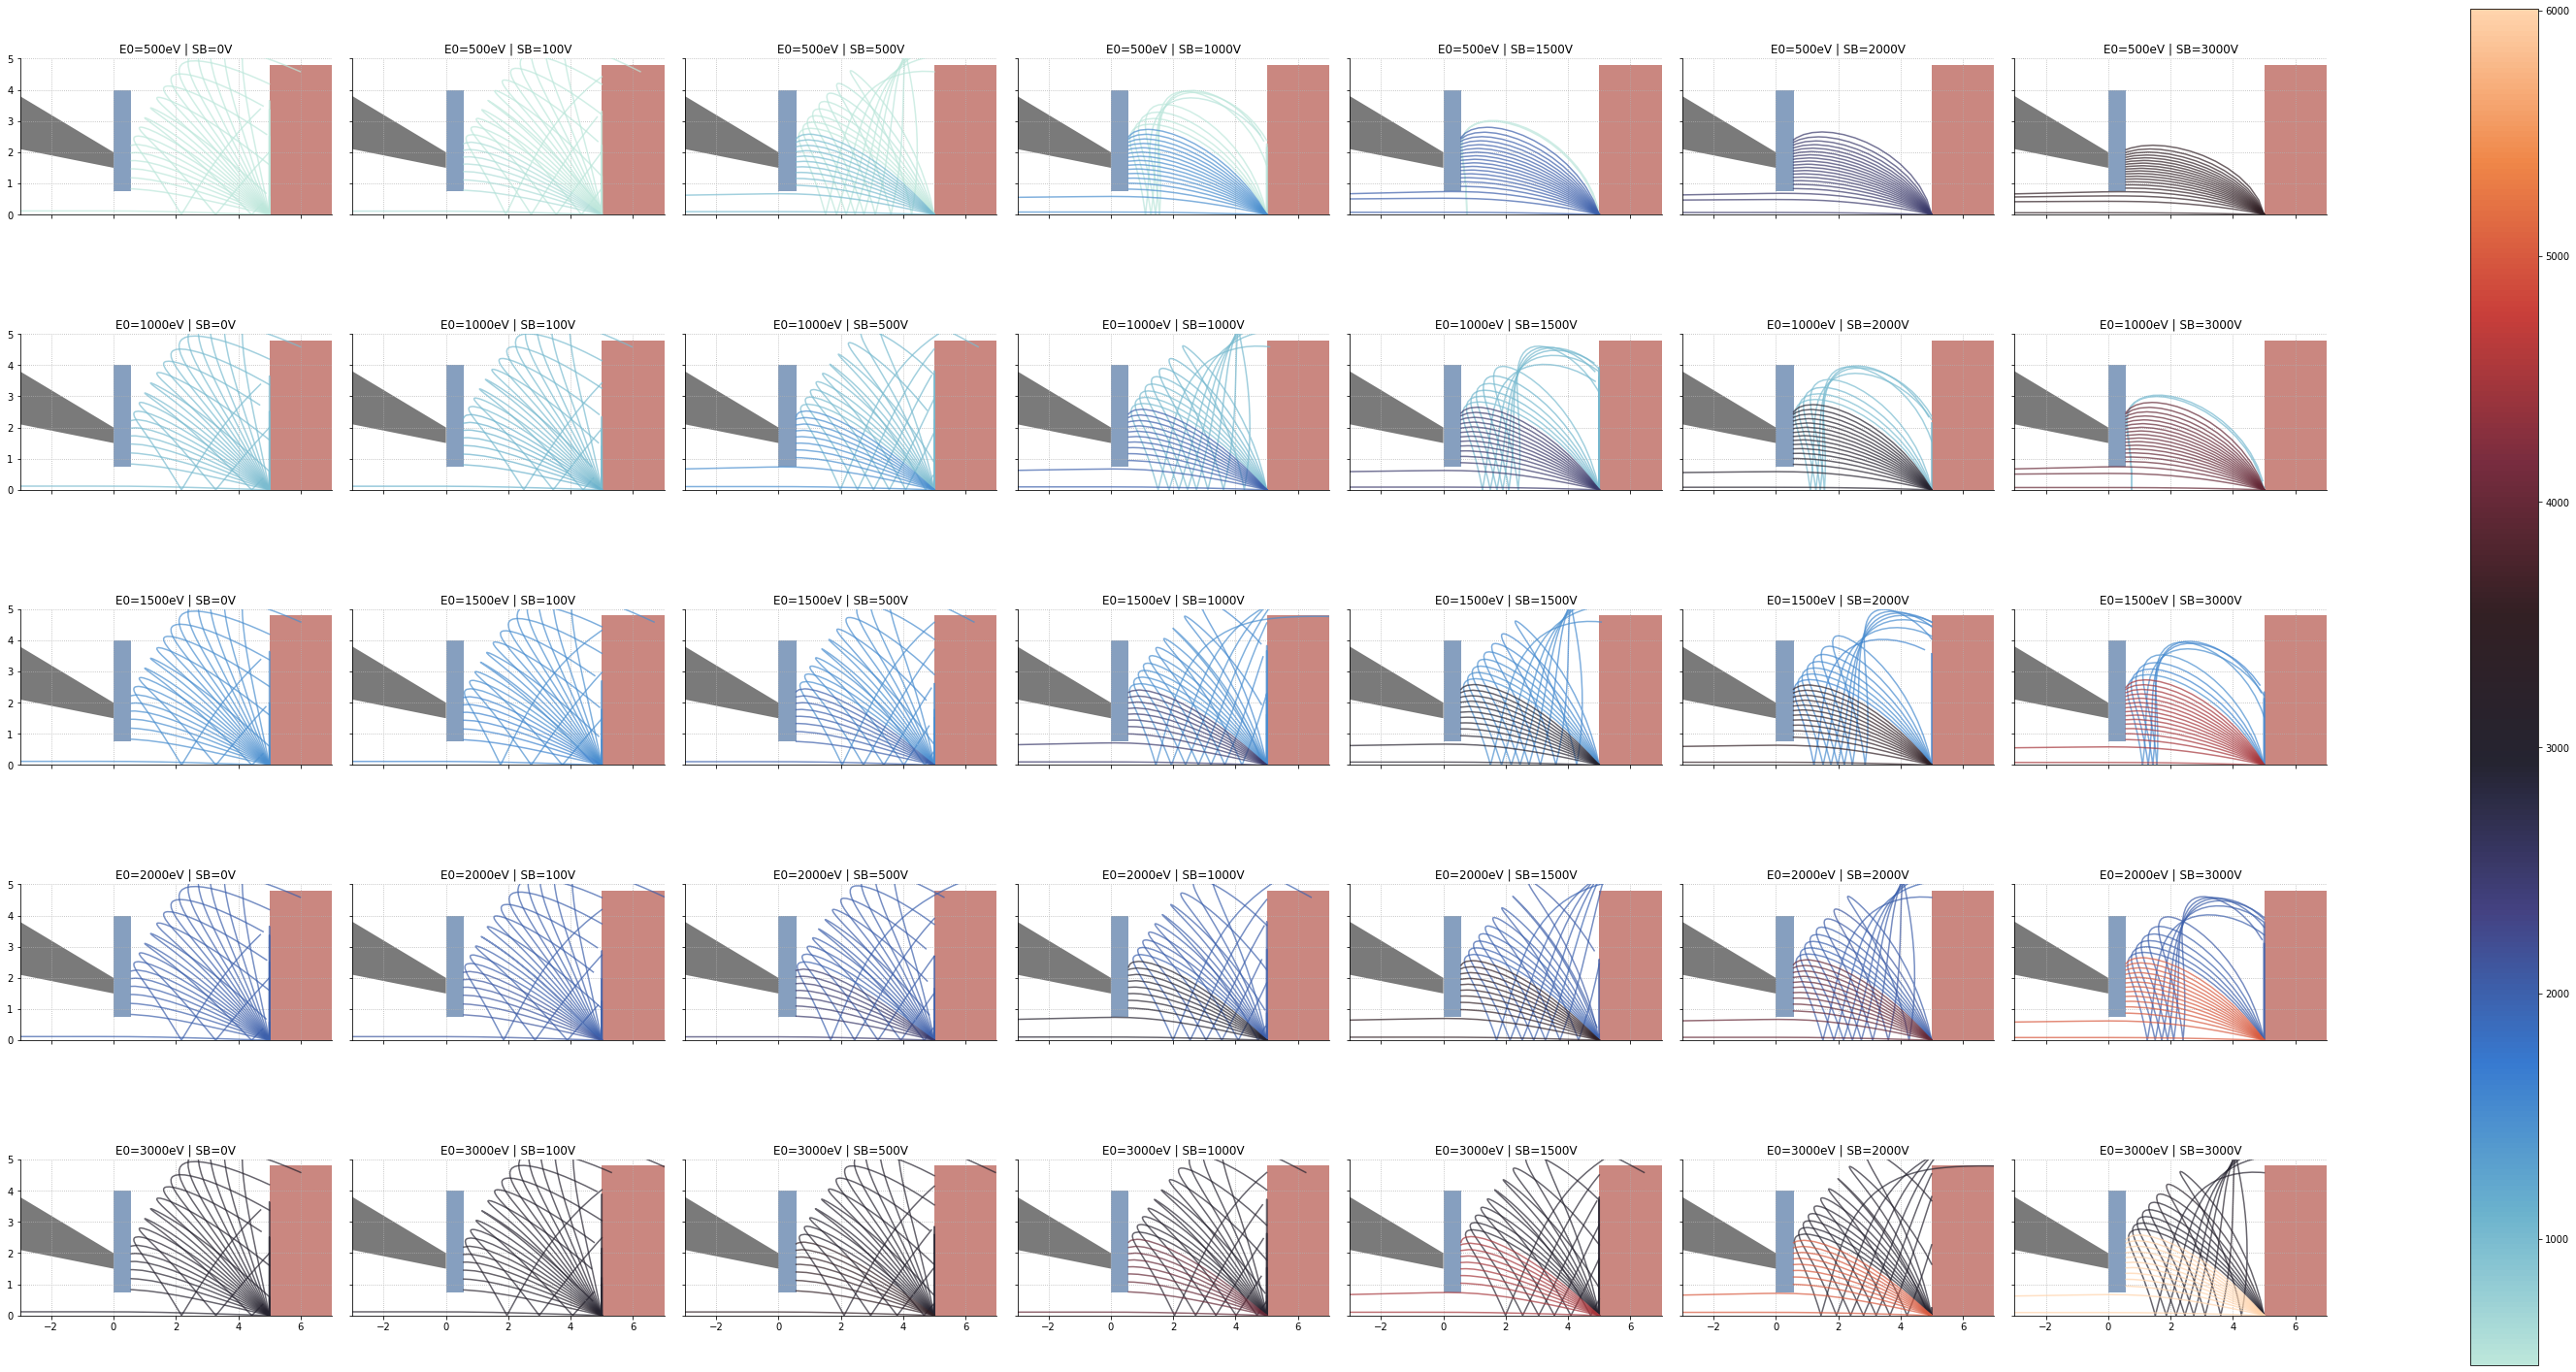

In [6]:
plot_trajectories(WD=5, mode='UHR')

## Analyzing BSE trajectories
---
For each landing energy, plot the percentage of BSEs that make it to the detector as a function of stage bias.

In [7]:
# Initialize DataFrame
df_hits = pd.DataFrame(columns=['E0', 'SB', '%'])

i = 0
for (WD_, mode, E0, SB), grp in df_trj.groupby(['WD', 'mode', 'E0', 'SB']):
    df_hits.loc[i, 'WD'] = WD_
    df_hits.loc[i, 'mode'] = mode
    df_hits.loc[i, 'E0'] = E0
    df_hits.loc[i, 'SB'] = SB
    df_hits.loc[i, '%'] = np.isclose(grp.groupby('i').apply(lambda x: x.iloc[-1])['Z'], 0.57, rtol=1e-3).sum()
    i += 1

df_hits = df_hits.infer_objects()
df_hits.sample(10)

E0      SB     %   WD mode
3     500.0  1000.0  84.0  3.0   HR
134  3000.0   100.0  32.0  4.0  UHR
47   1000.0  2000.0  70.0  3.0  UHR
276  3000.0  1000.0  39.0  6.0  UHR
160  1500.0  3000.0  73.0  5.0   HR
86   1500.0   500.0  60.0  4.0   HR
35    500.0     0.0  39.0  3.0  UHR
250   500.0  2000.0  92.0  6.0  UHR
260  1500.0   100.0  33.0  6.0  UHR
152  1000.0  2000.0  73.0  5.0   HR

### Sweeping different landing energies

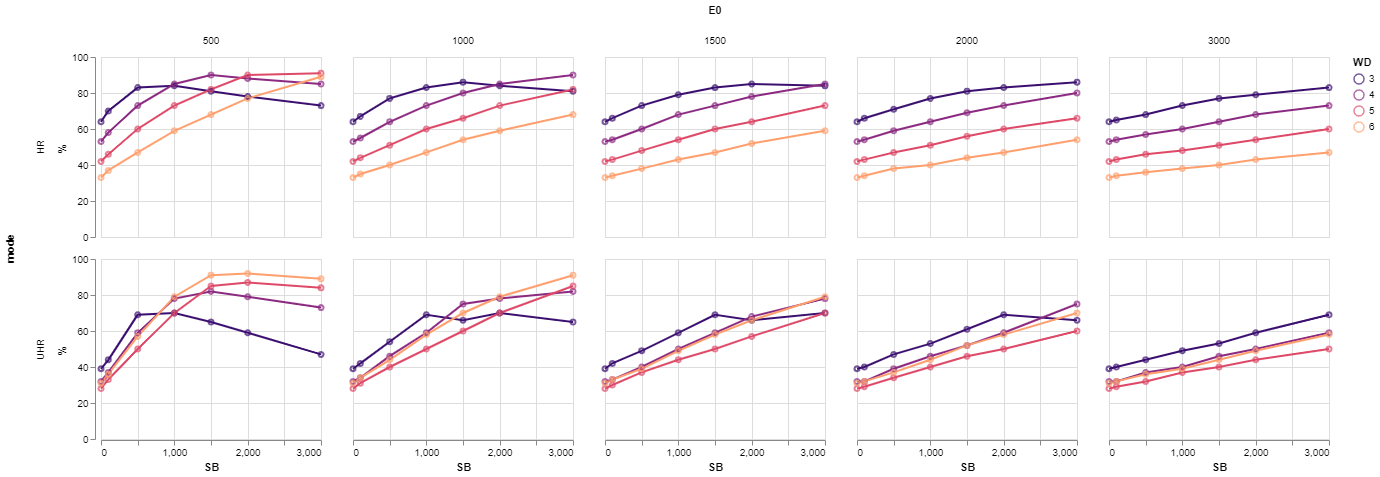

In [8]:
base = alt.Chart(df_hits).encode(
    alt.X('SB:Q', axis=alt.Axis(tickMinStep=500)),
    y='%:Q',
    color=alt.Color('WD:O', scale=alt.Scale(scheme='magma')),
).properties(
    width=220,
    height=180
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=25
    )
).facet(
    column='E0:N',
    row='mode:N'
)

chart

### Sweeping different working distances

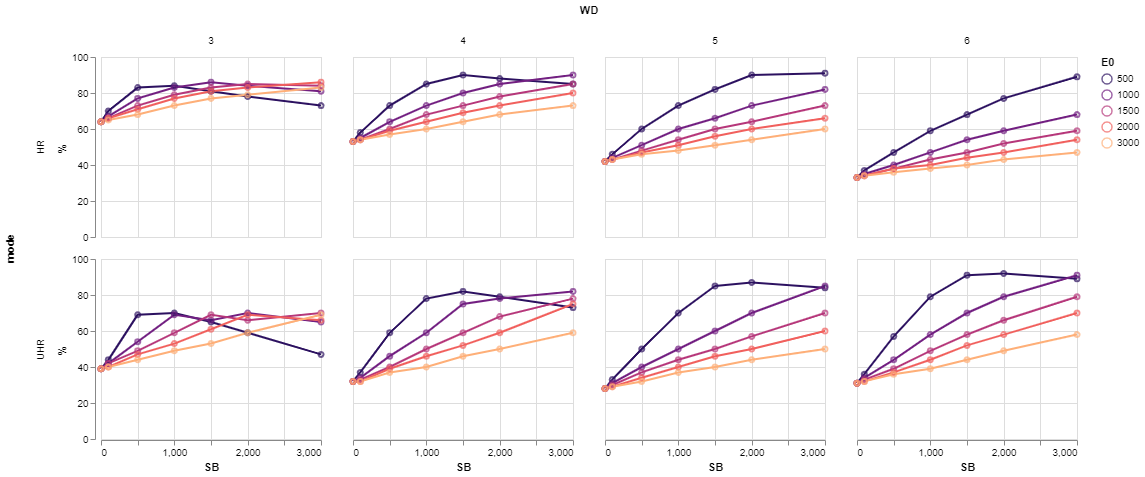

In [9]:
base = alt.Chart(df_hits).encode(
    alt.X('SB:Q', axis=alt.Axis(tickMinStep=500)),
    y='%:Q',
    color=alt.Color('E0:O', scale=alt.Scale(scheme='magma')),
).properties(
    width=220,
    height=180
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=25
    )
).facet(
    column='WD:N',
    row='mode:N'
)

chart

### More direct comparison of HR vs UHR mode

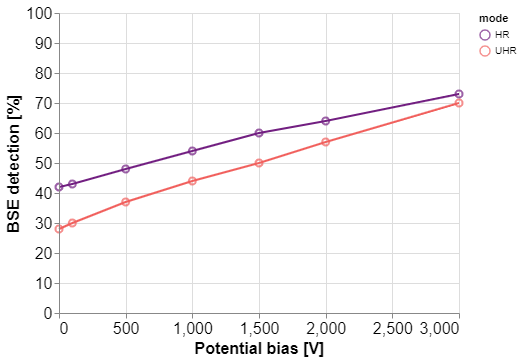

In [10]:
source = df_hits.loc[(df_hits['E0'] == 1500) &\
                     (df_hits['WD'] == 5)]

base = alt.Chart(source).encode(
    alt.X('SB:Q',
          axis=alt.Axis(tickMinStep=500,
                        title='Potential bias [V]')),
    alt.Y('%:Q',
          scale=alt.Scale(domain=[0, 100]),
          axis=alt.Axis(title='BSE detection [%]')),
    color=alt.Color('mode:O', scale=alt.Scale(scheme='magma')),
).properties(
    width=400,
    height=300
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=50
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16,
)

chart

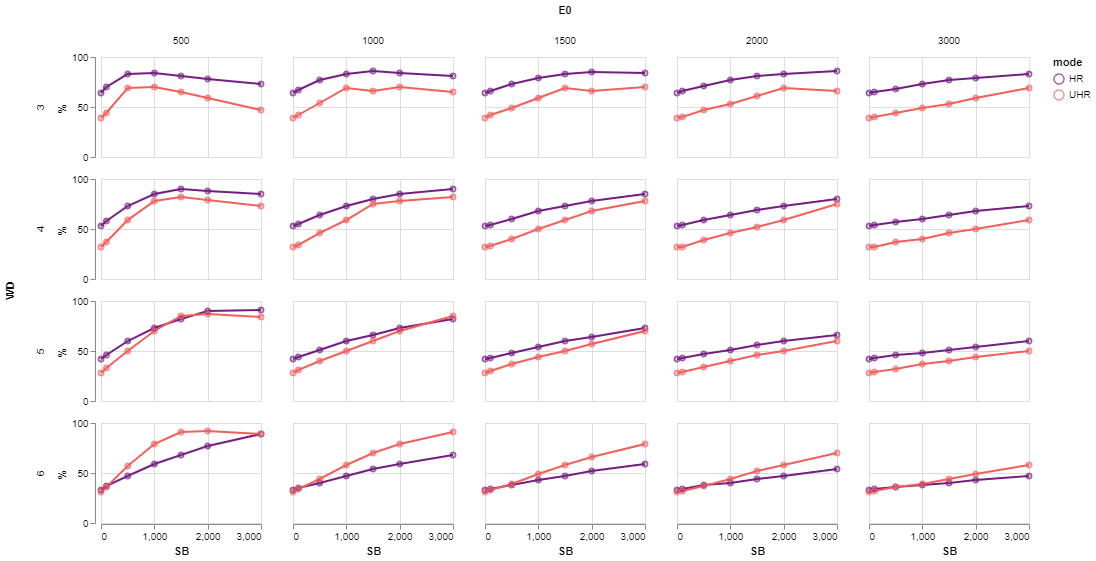

In [11]:
base = alt.Chart(df_hits).encode(
    alt.X('SB:Q', axis=alt.Axis(tickMinStep=500)),
    y='%:Q',
    color=alt.Color('mode:O', scale=alt.Scale(scheme='magma')),
).properties(
    width=160,
    height=100
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=25
    )
).facet(
    column='E0:N',
    row='WD:N'
)

chart

### % detected as a function of stage bias

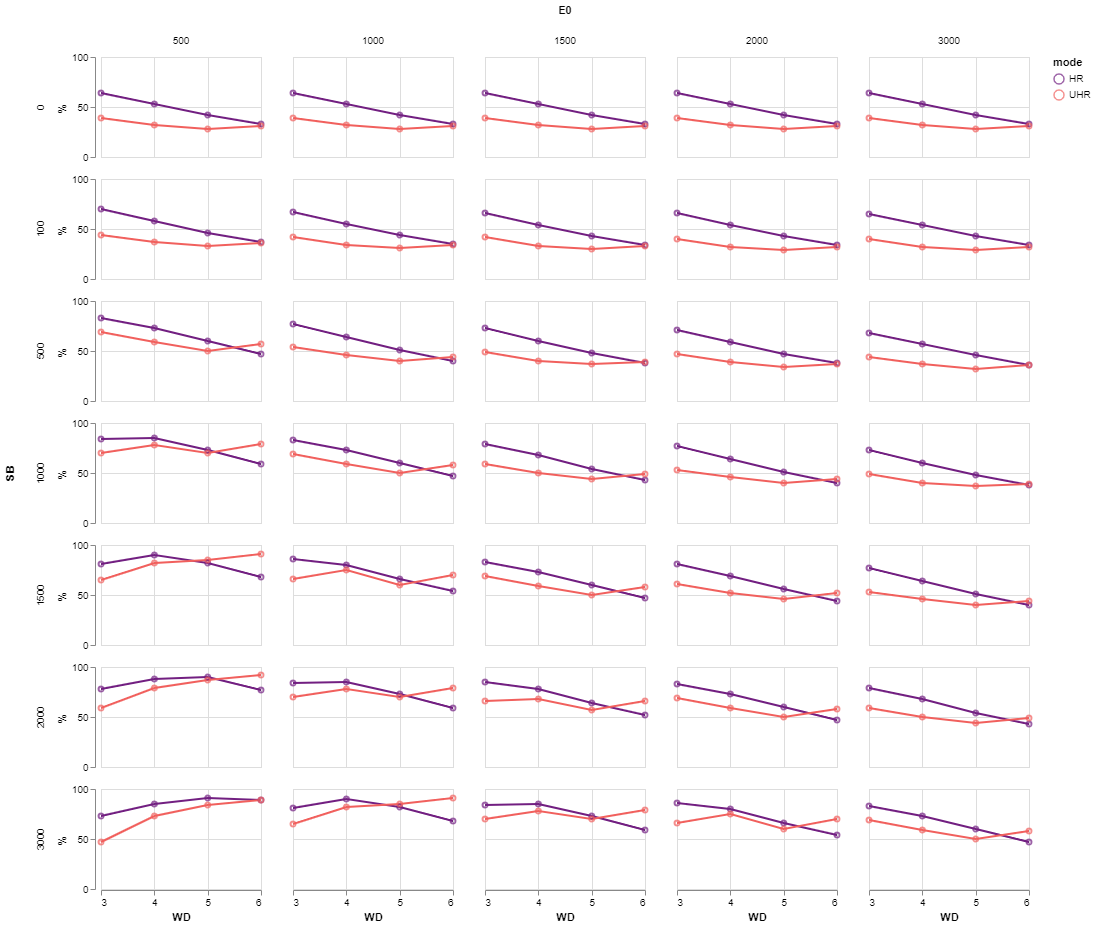

In [12]:
base = alt.Chart(df_hits).encode(
    alt.X('WD:Q',
          axis=alt.Axis(values=np.sort(df_hits['WD'].unique()).tolist())),
    alt.Y('%:Q'),
    color=alt.Color('mode:O', scale=alt.Scale(scheme='magma')),
).properties(
    width=160,
    height=100
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=25
    )
).facet(
    column='E0:N',
    row='SB:N'
)

chart